In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import MinMaxScaler

# Homework 3

К этому этапу данные уже почищены. Удалены NaN, дубликаты и некорректные данные. Убраны дескрипторы с высокими корреляциями и с низким распределением, а также "пустые", где 70% нулевых значений.

In [2]:
dataset = pd.read_csv('C:/Users/User/Desktop/Магистр Мира/Утёба/Algorithms and Big D---/Homework/datasets/clear_dataset.csv')

In [3]:
# Normalization 0 to -1
def data_normalization(dataset: pd.DataFrame) -> pd.DataFrame:
    scaler = MinMaxScaler().fit(dataset)
    scaled_data = scaler.transform(dataset)
    scaled_dataset = pd.DataFrame(scaled_data, columns=dataset.columns)
    return scaled_dataset

In [4]:
# Save and drop categorical and target features
target = dataset['gap']
categorical_columns = dataset['smiles']
dataset_descriptors = dataset.drop(columns=['gap', 'smiles'])

#Normalization of descriptors from 0 to -1
dataset_descriptors = data_normalization(dataset_descriptors)
dataset_descriptors.head()

A         B        mu     alpha      zpve        u0        cv  \
0  0.016047  0.143740  0.129969  0.606690  0.573633  0.429299  0.678717   
1  0.011112  0.085793  0.045161  0.679493  0.762121  0.424239  0.799466   
2  0.032769  0.100001  0.227651  0.581001  0.395484  0.512771  0.450179   
3  0.035751  0.088740  0.278095  0.351771  0.313725  0.323873  0.536361   
4  0.023569  0.072060  0.108942  0.562199  0.522248  0.387340  0.640841   

    SpAbs_A   SpMax_A     VE1_A  ...      GGI5      JGI4    Radius  \
0  0.773394  0.685154  0.821246  ...  0.000000  0.166667  0.333333   
1  0.763273  0.580393  0.647800  ...  0.194932  0.212143  0.666667   
2  0.806802  0.750196  0.815451  ...  0.280702  0.390625  0.666667   
3  0.539388  0.358425  0.721027  ...  0.000000  0.144000  0.666667   
4  0.714596  0.719811  0.705584  ...  0.280702  0.225000  0.666667   

   TopoShapeIndex  MinAbsEStateIndex       qed  MinPartialCharge  BCUT2D_MRHI  \
0        1.000000           0.210772  0.412813          0.580035     0.476857   
1        1.000000           0.214044  0.818353          0.581992     0.372729   
2        0.666667           0.248737  0.558510          0.801629     0.489409   
3        0.666667           0.480455  0.576513          0.498973     0.689211   
4        0.666667           0.205535  0.765626          0.574717     0.559822   

   BCUT2D_MRLOW  fr_bicyclic  
0      0.391358     0.111111  
1      0.413419     0.000000  
2      0.310926     0.000000  
3      0.415527     0.000000  
4      0.320364     0.111111  

[5 rows x 131 columns]

# Homework 4

In [5]:
# Зависимость explained variance от количества компонент
pca = PCA()
pca.fit(dataset_descriptors)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "Components", "y": "Explained Variance"})

In [6]:
# Находим количество компонент для объяснения 95% дисперсии
pca = PCA()

pca.fit(dataset_descriptors)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Количество компонент для дисперсии 95%
n_components = np.argmax(cumulative_explained_variance_ratio >= 0.95) + 1

print(f"Минимальное количество компонент для дисперсии 95%: {n_components}")

Минимальное количество компонент для дисперсии 95%: 48


In [7]:
# Построение зависимостей компонент для дисперсии >50% (7 компонент)
n_components = 7

pca = PCA(n_components=n_components)
components = pca.fit_transform(dataset_descriptors)

total_var = pca.explained_variance_ratio_.sum() * 100

labels = {str(i): f"PC {i+1}" for i in range(n_components)}

fig = px.scatter_matrix(
    components,
    dimensions=range(n_components),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()

<Axes: title={'center': 'Component Variance'}, xlabel='PCs', ylabel='Eigenvalues'>

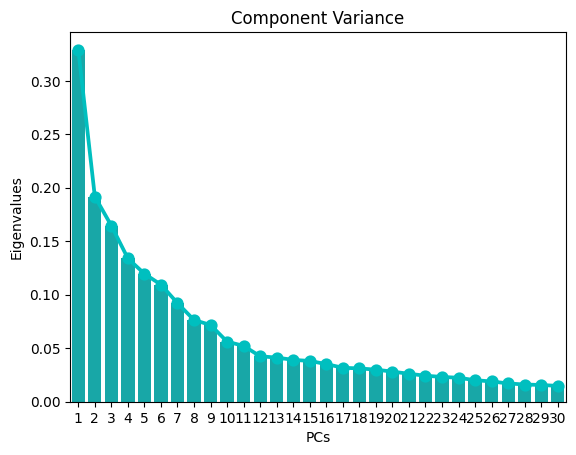

In [20]:
pca = PCA(n_components=48)
components = pca.fit_transform(dataset_descriptors)
dataset = pd.concat([target, pd.DataFrame(components)], axis=1)

# Объясненная корреляция для каждого PC
dfScree = pd.DataFrame({'Eigenvalues':pca.explained_variance_,'PCs':[i for i in range(1,pca.n_components_+1)]})

# Plot the variance explained by each component
sns.barplot(x='PCs',y="Eigenvalues",data=dfScree[0:30], color="c").set_title('Component Variance')
sns.pointplot(x='PCs',y="Eigenvalues",data=dfScree[0:30], color="c")

Мы видим, что наши данные являются «сферическими», наши компоненты захватывают очень небольшую долю общей дисперсии. Это в первую очередь говорит нам, что наши данные нелинейно-зависимы. Дополнительно к этому метод PCA очень чувствительный к выбросам, а у нас их много. В файле data_preprocessing я объяснял, почему в нашем случае не стоит удалять выбросы.

Для охвата 95% дисперсии требуется 48 компонент, что очень много, с такими данными нежелательно работать. Требуется применение нелинейных методов в связи с низкой плотностью охвата дисперсии нашими компонентами в линейном методе. 

In [9]:
# Зависимость explained variance от количества компонент
kpca = KernelPCA(n_components=10, kernel='rbf')
kpca_transform = kpca.fit_transform(dataset_descriptors)
explained_variance = np.var(kpca_transform, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
exp_var_cumul = np.cumsum(explained_variance_ratio)
px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "Components", "y": "Explained Variance"})

Нелиненое PCA способна покрыть 100% дисперсии.

In [22]:
dataset.to_csv('C:/Users/User/Desktop/Магистр Мира/Утёба/Algorithms and Big D---/Homework/datasets/final_dataset.csv', index=False)